# Mechanics of LoRA Fine‑Tuning for **FLUX.2 [klein] Base** (Non‑Distilled)
## What Actually Matters


FLUX.2 [klein] **Base** (non‑distilled, flow matching, 50 steps) — not the distilled Klein models.

---

**Session map (45 min)**
1. Why Klein Base behaves differently
2. Where LoRA goes and what it learns
3. Hyperparameters that actually move the needle
4. Data strategy + failure diagnosis 
5. Practical recipe + Q&A 


In [166]:
# Display helper for local SVGs
from pathlib import Path
from IPython.display import SVG, display

ASSETS = Path('assets')

print('Ready')


Ready


---
# 1) Why **Klein** behaves differently

A undistilled model made for Customization and LoRA. 
FLUX.2 [klein] learns concepts quickly, those notes are based on my personal experience with FLUX models and a bit with FLUX.2 [klein] 

LoRA feels *more stable* on Klein Base, but it can still overfit quickly on small datasets.


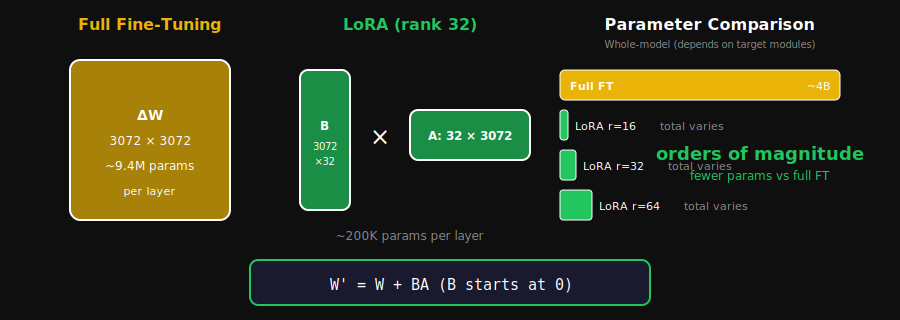

In [167]:
# Parameter‑efficiency reminder (keep light)
display(SVG(ASSETS / 'lora_decomposition.svg'))

---
# 2) Where LoRA goes (and why it matters)

Klein has **double‑stream** blocks followed by **single‑stream** blocks. This yields a useful targeting map:

- **Double‑stream (0–4)**: text‑image binding (trigger ↔ concept).
- **Single early (5–10)**: texture, color, low‑level style.
- **Single mid (11–18)**: parts, identity, structure.
- **Single late (19–24)**: composition & layout.


In [168]:
# Architecture overview
display(SVG(ASSETS / 'klein_architecture.svg'))


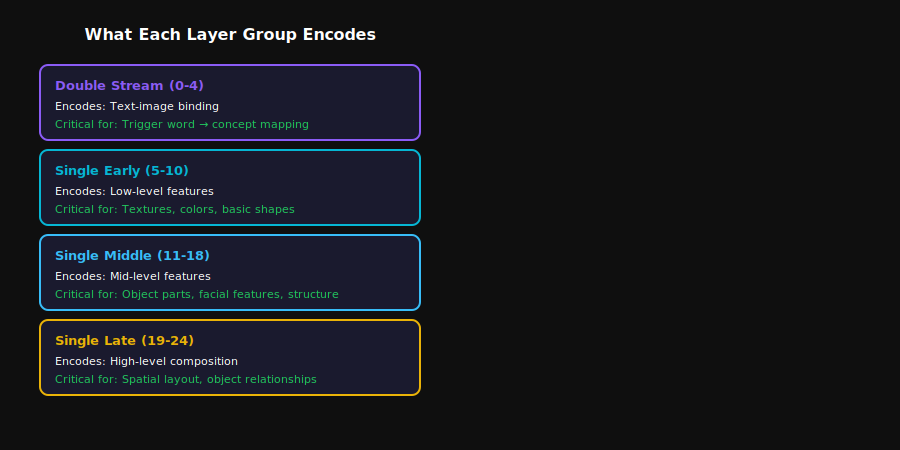

In [169]:
# Layer‑wise intuition + targeting options
display(SVG(ASSETS / 'layer_analysis.svg'))


---
# 3) Hyperparameters that actually matter

Four knobs drive most outcomes:
- **Rank** (capacity)
- **Alpha** (strength scaling)
- **Learning rate** (speed)
- **Steps** (duration)

**Recommended starting points (Klein Base 4B)**
- **Style**: rank 16, alpha 16, lr 3e‑4, 500–800 steps
- **Character / Face**: rank 32, alpha 32, lr 2e‑4, 800–1200 steps
- **Object / Product**: rank 24, alpha 24, lr 2e‑4, 600–1000 steps
- **I2I Transform**: rank 32, alpha 32, lr 1e‑4, 250–500 steps

**Key insight**: `alpha/rank` ≈ effective strength. Keeping it ≈1.0 is a safe default.


## 3.1 Rank vs Alpha

What *changes* when you touch them

**Rank = capacity** (how much detail the LoRA can store).
**Alpha = strength** (how loud that stored change is).

**Guidelines**
- Keep **alpha ≈ rank** to start.
- If concept is *weak* → increase **rank** before increasing **alpha**.
- If concept is *too strong / bleeds* → reduce **alpha** or steps.

Two LoRAs with the same `alpha/rank` ratio can still behave differently. Higher rank usually *generalizes* better but can overfit faster.


## 3.2 Learning Rate × Steps

**Rule of thumb**
- Higher LR → fewer steps, faster learning, higher instability risk.
- Lower LR → more steps, stable but can underfit.

**Start here (Klein Base 4B)**
- LR **1e‑4 to 3e‑4**
- Steps **500–1200**



## 3.2.1 Concept strength vs prompt flexibility (intuition)

- As steps increase, **concept strength** rises.
- After a point, **prompt flexibility** drops (overfitting).

The goal is to stop at the *peak of concept strength* **before** flexibility collapses.


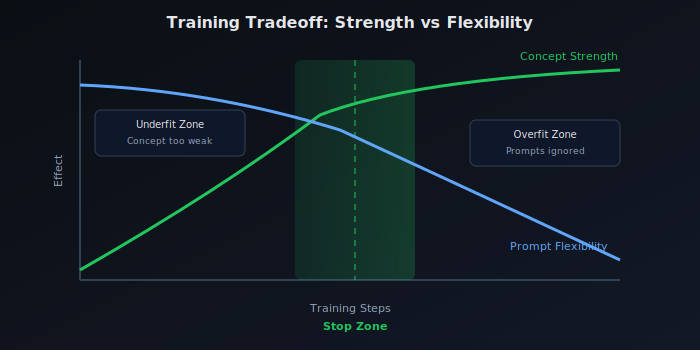

In [170]:
# Strength vs Flexibility tradeoff
display(SVG(ASSETS / 'strength_flexibility_tradeoff.svg'))

---
## 3.3 Comparison: Rank and Steps

**Setup**
- Same dataset (filmlut style transfer)
- Same trigger word (`filmlut`)
- Varied: **rank** (8, 16, 32) and **steps** (250, 500, 1000)


In [171]:
# Setup: Load samples from training runs
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import re

SAMPLES_DIR = Path("/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples")

def get_final_sample(lora_name, prompt_idx=0):
    """Get the final (highest step) sample for a config and prompt."""
    prompt_dirs = {
        0: "prompt0_woman",
        1: "prompt1_mountains",
        2: "prompt2_man",
        3: "prompt3_other"
    }
    prompt_dir = SAMPLES_DIR / prompt_dirs.get(prompt_idx, "prompt0_woman")
    
    if not prompt_dir.exists():
        return None
    
    # Find all samples for this config
    pattern = f"{lora_name}_*_{prompt_idx}.jpg"
    samples = list(prompt_dir.glob(pattern))
    
    if not samples:
        return None
    
    # Sort by step number and return the last one
    def get_step(path):
        match = re.search(r'__(\d+)_\d+\.jpg$', path.name)
        return int(match.group(1)) if match else 0
    
    samples.sort(key=get_step)
    return Image.open(samples[-1])

print(f"Sample directories: {list(SAMPLES_DIR.iterdir())}")
print("Ready to display comparisons!")

Sample directories: [PosixPath('/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples/prompt1_mountains'), PosixPath('/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples/.DS_Store'), PosixPath('/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples/prompt3_other'), PosixPath('/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples/prompt0_woman'), PosixPath('/Users/stephen/Documents/bfl/flux_workshops/assets/all_samples/prompt2_man')]
Ready to display comparisons!


### Rank Comparison (8 → 16 → 32)

All trained for **500 steps**. Same prompt.

**Typical pattern**
- Style strength usually increases with rank.
- Diminishing returns often appear after rank 32.
- Watch for artifacts at higher capacity.


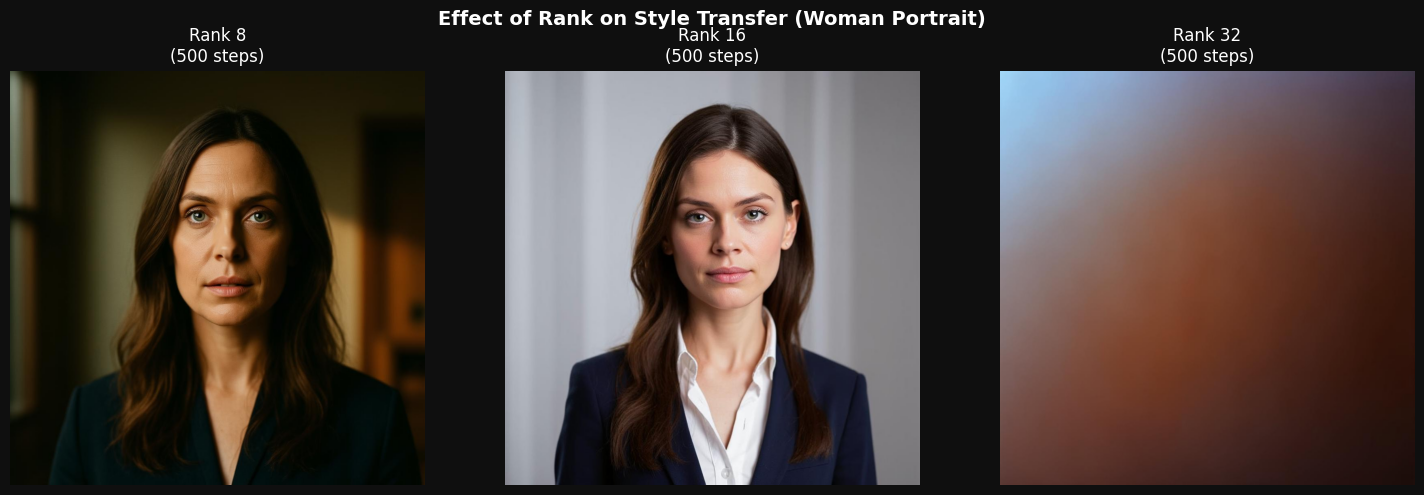

In [172]:
# Compare different ranks at 500 steps (woman portrait)
ranks = [8, 16, 32]
images_by_rank = {}

for rank in ranks:
    lora_name = f"filmlut_r{rank}_s500"
    img = get_final_sample(lora_name, prompt_idx=0)
    if img:
        images_by_rank[rank] = img

# Display comparison
fig, axes = plt.subplots(1, len(images_by_rank), figsize=(5*len(images_by_rank), 5))
if len(images_by_rank) == 1:
    axes = [axes]

for i, rank in enumerate(images_by_rank.keys()):
    axes[i].imshow(images_by_rank[rank])
    axes[i].set_title(f"Rank {rank}\n(500 steps)", fontsize=12)
    axes[i].axis('off')

plt.suptitle("Effect of Rank on Style Transfer (Woman Portrait)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Steps Comparison (250 → 500 → 1000)

All at **rank 16**.

**Typical pattern**
- 250 steps: concept begins to appear.
- 500 steps: clearer concept with better flexibility.
- 1000 steps: stronger concept, higher overfit risk.


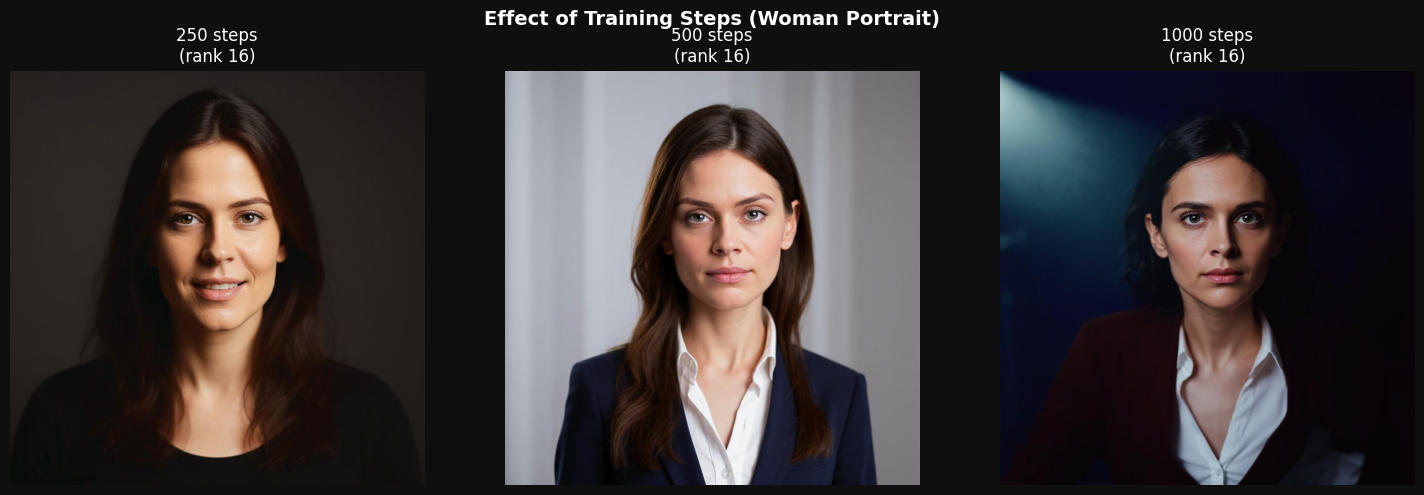

In [173]:
# Compare different training steps at rank 16
steps_list = [250, 500, 1000]
images_by_steps = {}

for steps in steps_list:
    lora_name = f"filmlut_r16_s{steps}"
    img = get_final_sample(lora_name, prompt_idx=0)
    if img:
        images_by_steps[steps] = img

# Display comparison
fig, axes = plt.subplots(1, len(images_by_steps), figsize=(5*len(images_by_steps), 5))
if len(images_by_steps) == 1:
    axes = [axes]

for i, steps in enumerate(images_by_steps.keys()):
    axes[i].imshow(images_by_steps[steps])
    axes[i].set_title(f"{steps} steps\n(rank 16)", fontsize=12)
    axes[i].axis('off')

plt.suptitle("Effect of Training Steps (Woman Portrait)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Generalization Test: Does it work on different subjects?

A good LoRA applies the style across **different subjects**, not just the training images.

Test prompts used:
- **Prompt 0**: Woman portrait (cinematic)
- **Prompt 1**: Mountain landscape
- **Prompt 2**: Man portrait
- **Prompt 3**: Other


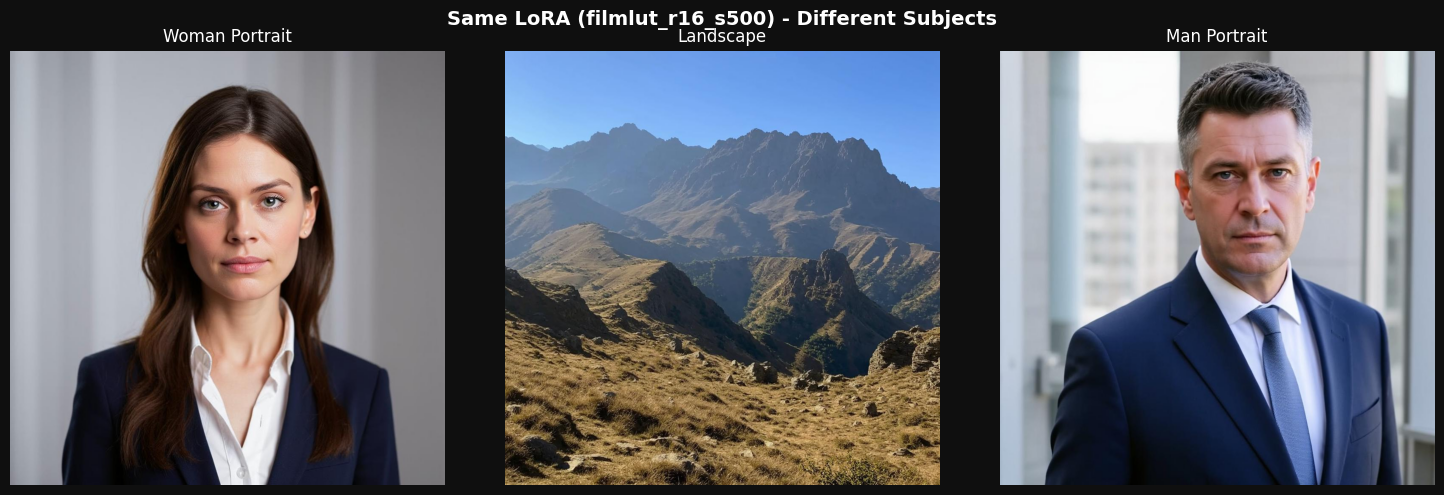

In [174]:
# Generalization test: same LoRA, different prompts
lora_name = "filmlut_r16_s500"  # Our "sweet spot" config

prompt_labels = ["Woman Portrait", "Landscape", "Man Portrait"]
images = []

for prompt_idx in range(3):
    img = get_final_sample(lora_name, prompt_idx=prompt_idx)
    if img:
        images.append((prompt_labels[prompt_idx], img))

fig, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5))
if len(images) == 1:
    axes = [axes]

for i, (label, img) in enumerate(images):
    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=12)
    axes[i].axis('off')

plt.suptitle(f"Same LoRA ({lora_name}) - Different Subjects", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Key Takeaways from the Comparisons

**Rank**
- Higher rank = more capacity to learn detail
- Rank 8–16 is often sufficient for style transfer
- Diminishing returns after rank 32

**Generalization**
- Style should transfer across portraits and landscapes
- This indicates the LoRA learned the *style*, not memorized images

**Stop training** when samples look good **and** the style transfers to new subjects.


### Multi-Subject Grid: Same LoRA settings, different prompts

The goal is consistent style across **different subjects**.


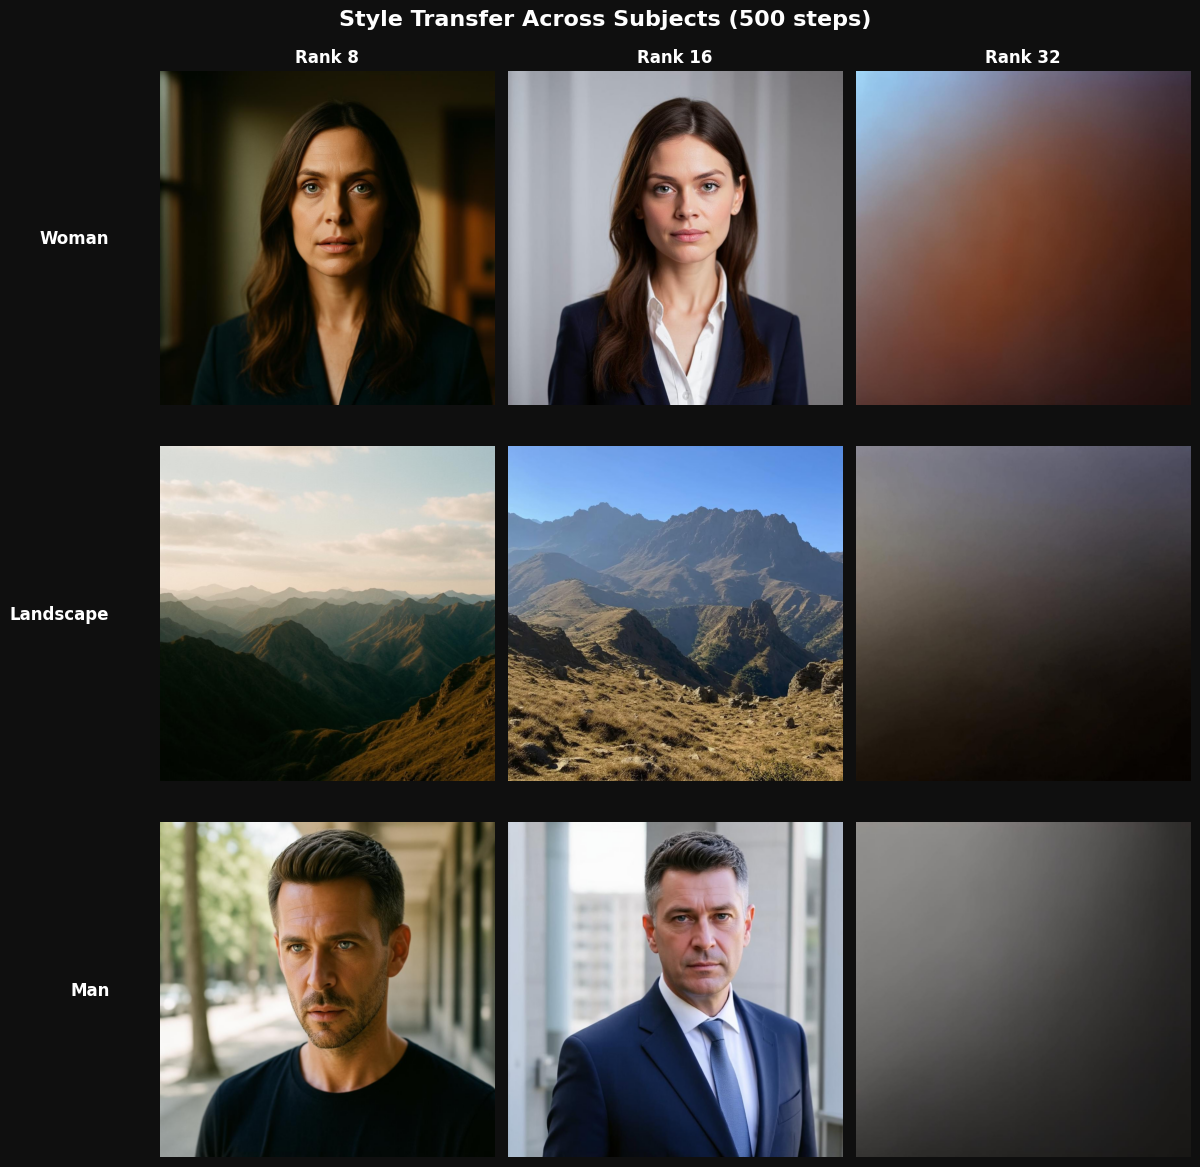


The filmlut cinematic style should be visible in ALL cells.
This proves generalization - the LoRA learned the STYLE, not specific images.


In [175]:
# Multi-subject grid: rows = prompts, columns = configs
configs = ["filmlut_r8_s500", "filmlut_r16_s500", "filmlut_r32_s500"]
prompt_labels = ["Woman", "Landscape", "Man"]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, prompt_idx in enumerate(range(3)):
    for j, config in enumerate(configs):
        img = get_final_sample(config, prompt_idx=prompt_idx)
        if img:
            axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
        if i == 0:
            rank = config.split('_')[1]  # e.g., "r8"
            axes[i, j].set_title(f"Rank {rank[1:]}", fontsize=12, fontweight='bold')

# Row labels
for i, label in enumerate(prompt_labels):
    axes[i, 0].annotate(label, xy=(-0.15, 0.5), xycoords='axes fraction',
                        fontsize=12, fontweight='bold', ha='right', va='center')

plt.suptitle("Style Transfer Across Subjects (500 steps)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nThe filmlut cinematic style should be visible in ALL cells.")
print("This proves generalization - the LoRA learned the STYLE, not specific images.")

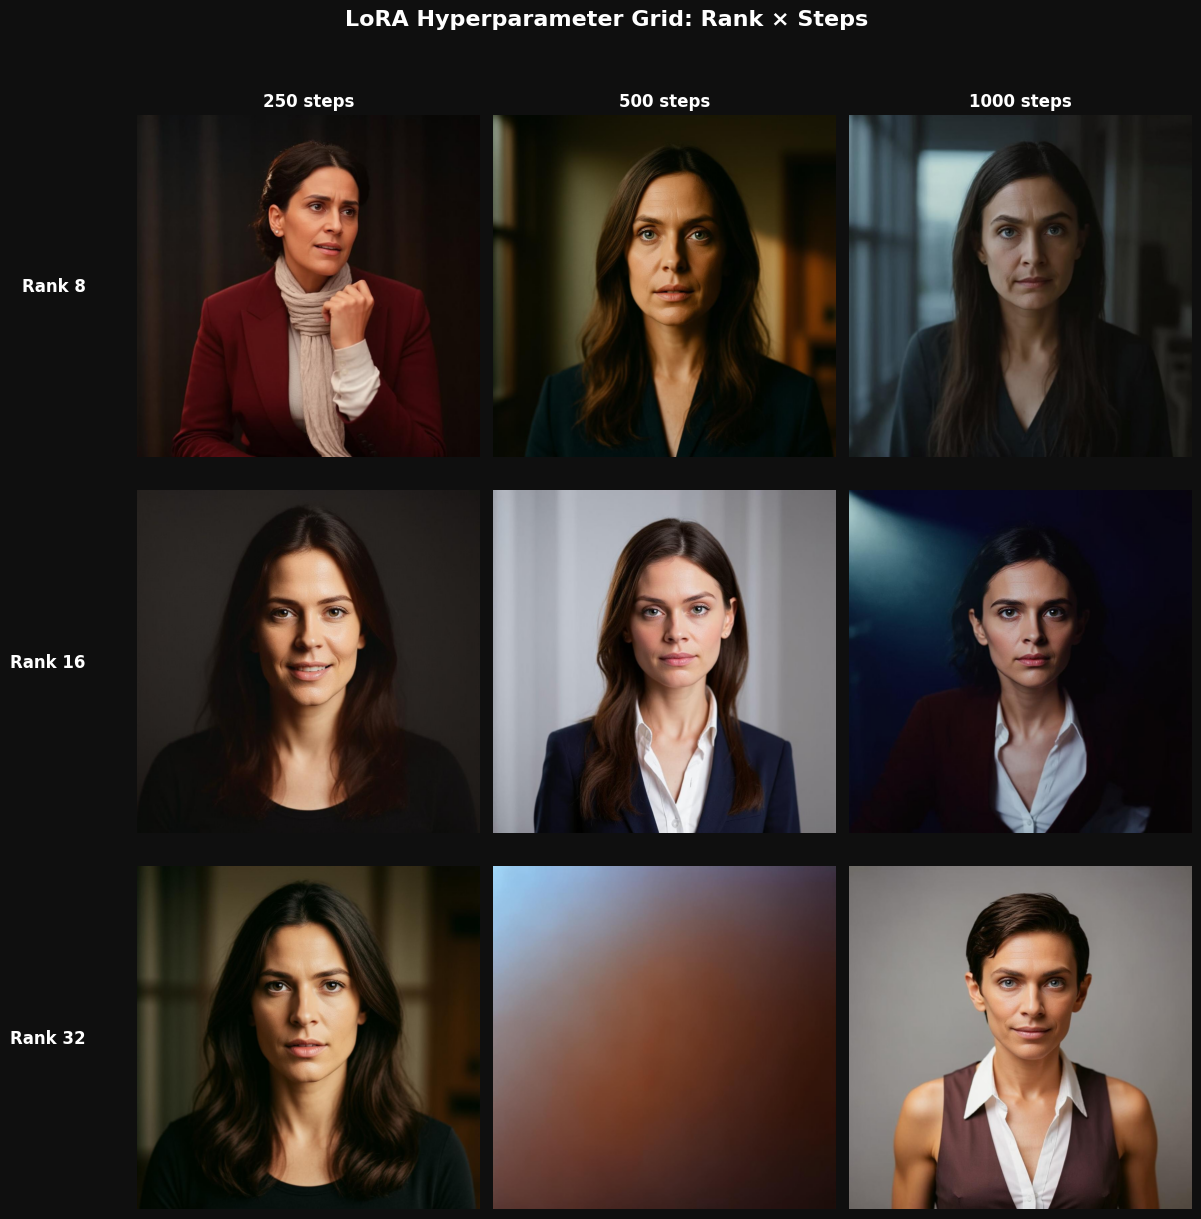


Reading the grid:
→ Left to right: more training (250 → 500 → 1000 steps)
↓ Top to bottom: more capacity (rank 8 → 16 → 32)

Sweet spot for this task: rank 16, 500 steps


In [176]:
# Full grid comparison: rank x steps (woman portrait)
ranks = [8, 16, 32]
steps_list = [250, 500, 1000]

grid_images = {}
for rank in ranks:
    for steps in steps_list:
        lora_name = f"filmlut_r{rank}_s{steps}"
        grid_images[(rank, steps)] = get_final_sample(lora_name, prompt_idx=0)

# Display as grid
fig, axes = plt.subplots(len(ranks), len(steps_list), figsize=(12, 12))

for i, rank in enumerate(ranks):
    for j, steps in enumerate(steps_list):
        img = grid_images.get((rank, steps))
        if img:
            axes[i, j].imshow(img)
        else:
            axes[i, j].text(0.5, 0.5, "N/A", ha='center', va='center', fontsize=20)
        axes[i, j].axis('off')
        
        if i == 0:
            axes[i, j].set_title(f"{steps} steps", fontsize=12, fontweight='bold')

# Add row labels
for i, rank in enumerate(ranks):
    axes[i, 0].annotate(f"Rank {rank}", xy=(-0.15, 0.5), xycoords='axes fraction',
                        fontsize=12, fontweight='bold', ha='right', va='center')

plt.suptitle("LoRA Hyperparameter Grid: Rank × Steps", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nReading the grid:")
print("→ Left to right: more training (250 → 500 → 1000 steps)")
print("↓ Top to bottom: more capacity (rank 8 → 16 → 32)")
print("\nSweet spot for this task: rank 16, 500 steps")

## 8.2 Weight Tuning

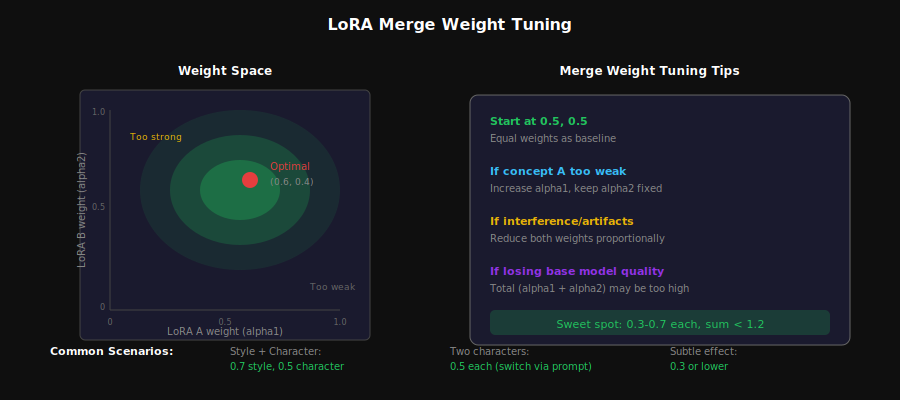

In [177]:
display(SVG(ASSETS / 'merge_weights.svg'))

## Dataset size by task (Klein Base)

- **Style**: 50–200 images
- **Character / face**: 20–60 images (highly curated)
- **Object / product**: 30–100 images
- **I2I transformation**: 30–100 *pairs*

**Golden rule:** 20 excellent images > 200 mediocre images.


### Example: training pairs (reference → target)

These pairs show the mapping the model is expected to learn.


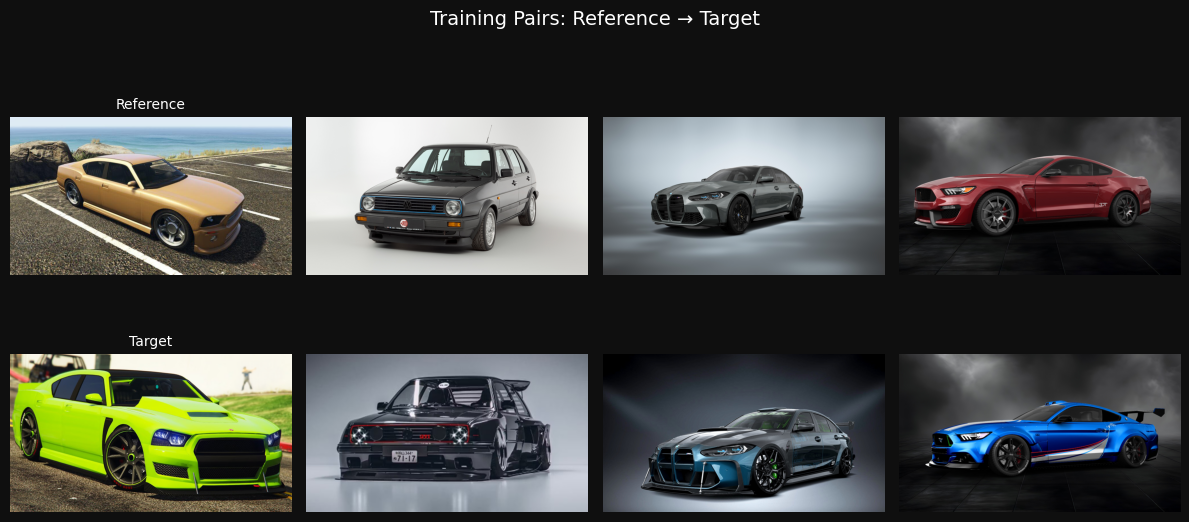

In [178]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

DATA_DIR = Path('training_data')
refs = DATA_DIR / 'pimpmyride_control'
tgts = DATA_DIR / 'pimpmyride'

pairs = ['001', '003', '017', '037']
fig, axes = plt.subplots(2, len(pairs), figsize=(12, 6))
for i, idx in enumerate(pairs):
    ref_path = refs / f'{idx}.png'
    tgt_path = tgts / f'{idx}.png'
    if ref_path.exists():
        axes[0, i].imshow(Image.open(ref_path))
    axes[0, i].axis('off')
    axes[0, i].set_title('Reference' if i == 0 else '', fontsize=10)

    if tgt_path.exists():
        axes[1, i].imshow(Image.open(tgt_path))
    axes[1, i].axis('off')
    axes[1, i].set_title('Target' if i == 0 else '', fontsize=10)

plt.suptitle('Training Pairs: Reference → Target', fontsize=14)
plt.tight_layout()
plt.show()


---
# Training Results

## The Task: Pimp My Ride

We trained Klein Base to transform regular cars into custom "pimped" versions.

**Training Config:**
```yaml
model: FLUX.2-Klein-Base-4B
rank: 32, alpha: 32
lr: 1e-4
steps: 500
dataset: 44 image pairs
```

## The Training Data

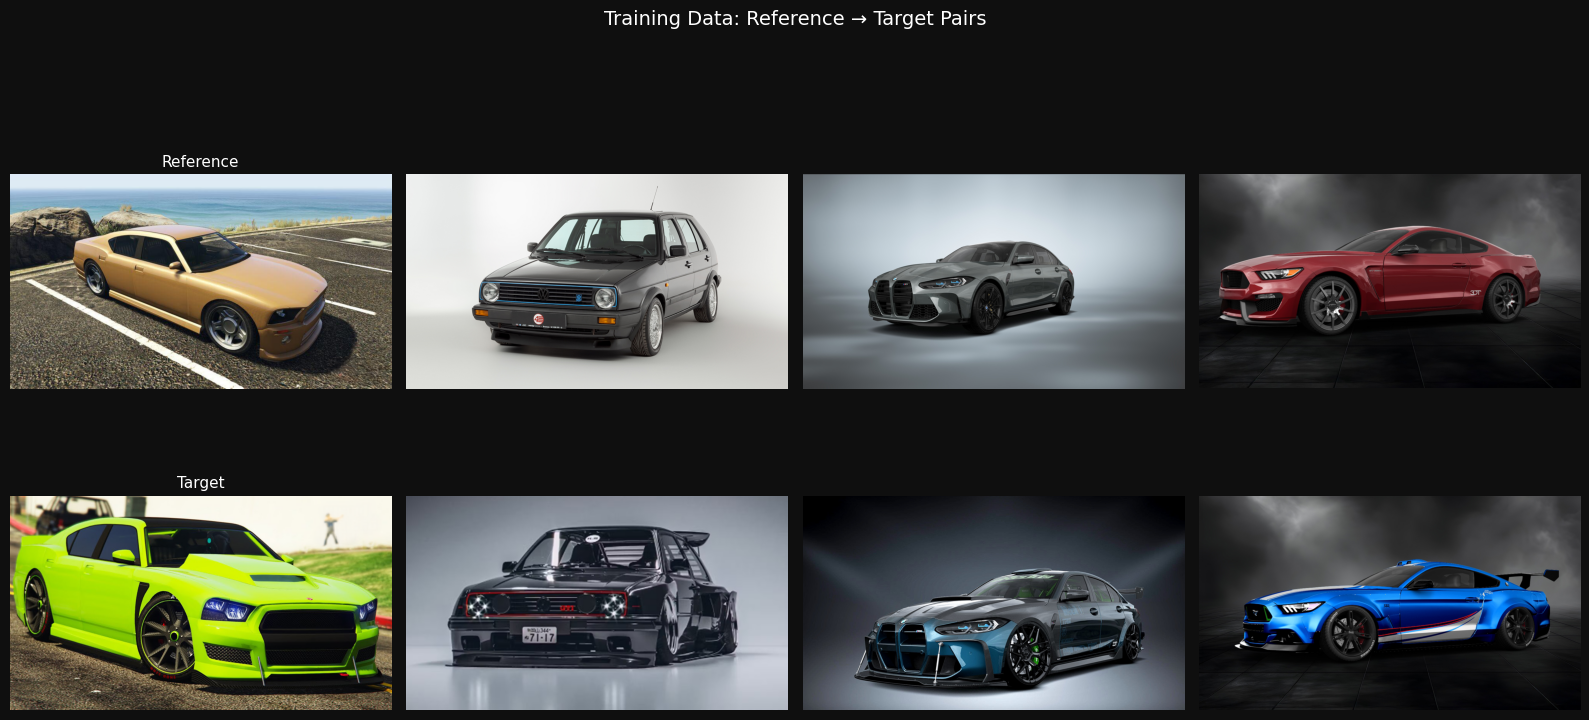

Dataset: 44 pairs | Diverse car types | Unique captions per image


In [179]:
# Training data samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
pairs = ['001', '003', '017', '037']

for i, idx in enumerate(pairs):
    ref_path = DATA_DIR / 'pimpmyride_control' / f'{idx}.png'
    if ref_path.exists():
        axes[0, i].imshow(Image.open(ref_path))
    axes[0, i].axis('off')
    axes[0, i].set_title('Reference' if i == 0 else '', fontsize=11, color='white')
    
    tgt_path = DATA_DIR / 'pimpmyride' / f'{idx}.png'
    if tgt_path.exists():
        axes[1, i].imshow(Image.open(tgt_path))
    axes[1, i].axis('off')
    axes[1, i].set_title('Target' if i == 0 else '', fontsize=11, color='white')

plt.suptitle('Training Data: Reference → Target Pairs', fontsize=14, y=1.02, color='white')
plt.tight_layout()
plt.show()
print("Dataset: 44 pairs | Diverse car types | Unique captions per image")

## Training Progression

Here's what the model generated at each checkpoint. Same prompt throughout:

`"pimpmyride, a sports car"`

Ready


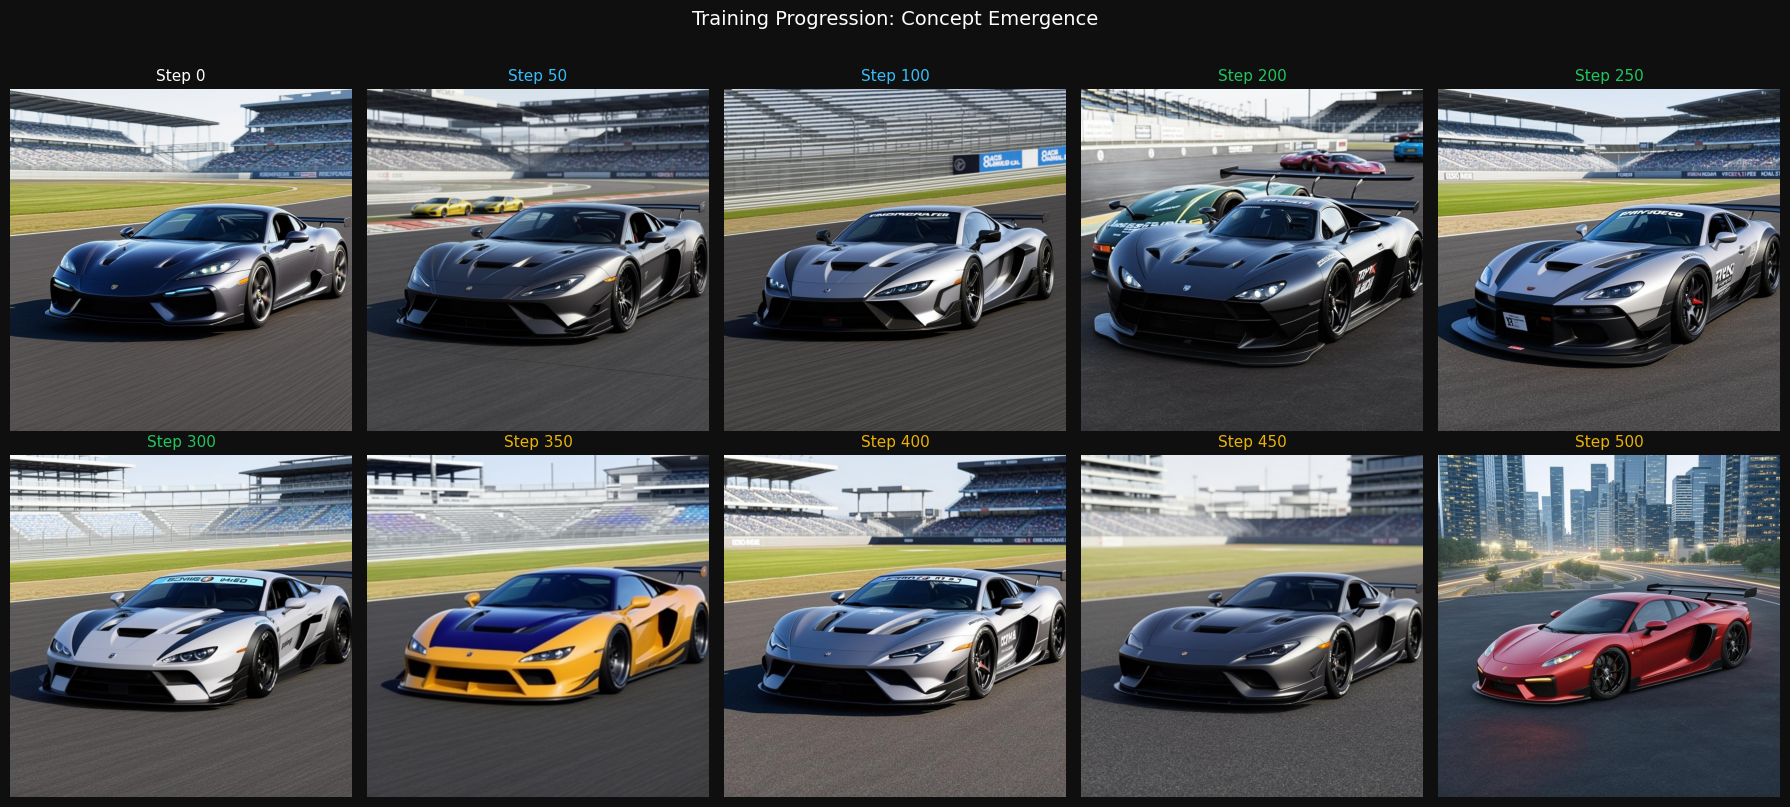

In [180]:

# Setup for demo images only
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')
plt.rcParams.update({'figure.facecolor': '#0f0f0f', 'axes.facecolor': '#0f0f0f'})

SAMPLES_DIR = Path('samples')
DATA_DIR = Path('training_data')

print('Ready')


# Training progression
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

step_files = {
    0: '1768946967141__000000000_0.jpg',
    50: '1768947077803__000000050_0.jpg',
    100: '1768947186514__000000100_0.jpg',
    200: '1768947404491__000000200_0.jpg',
    250: '1768947514157__000000250_0.jpg',
    300: '1768947621817__000000300_0.jpg',
    350: '1768947732234__000000350_0.jpg',
    400: '1768947841399__000000400_0.jpg',
    450: '1768947950571__000000450_0.jpg',
    500: '1768948054553__000000500_0.jpg',
}

steps = [0, 50, 100, 200, 250, 300, 350, 400, 450, 500]
colors = {'early': '#38bdf8', 'learning': '#22c55e', 'converging': '#eab308'}

for i, step in enumerate(steps):
    row, col = i // 5, i % 5
    ax = axes[row, col]
    
    img_path = SAMPLES_DIR / step_files[step]
    if img_path.exists():
        ax.imshow(Image.open(img_path))
    
    color = 'white' if step == 0 else colors['early'] if step <= 100 else colors['learning'] if step <= 300 else colors['converging']
    ax.set_title(f'Step {step}', fontsize=11, color=color)
    ax.axis('off')

plt.suptitle('Training Progression: Concept Emergence', fontsize=14, y=1.02, color='white')
plt.tight_layout()
plt.show()

## Loss Curve Analysis

What the numbers tell us:

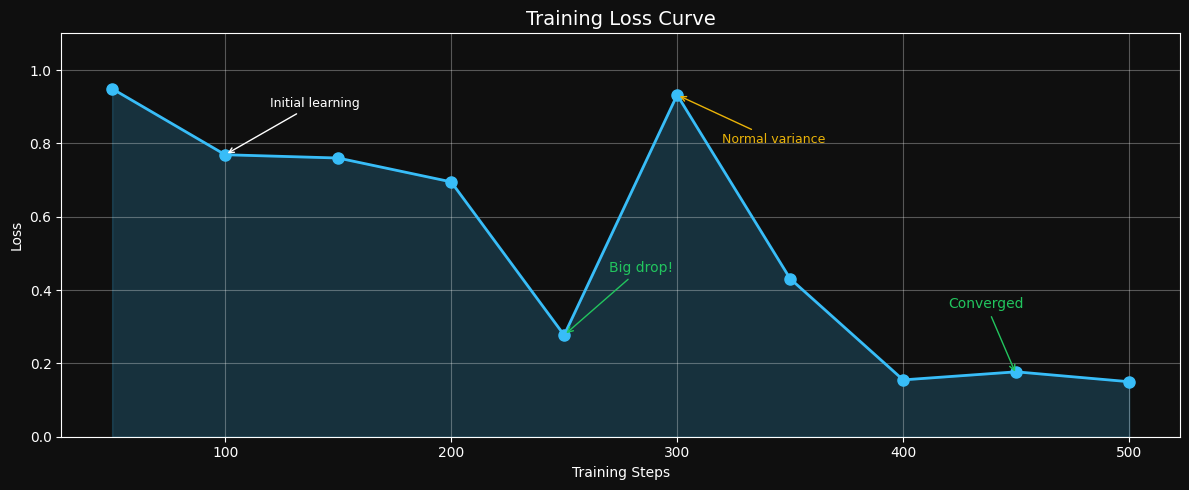

Observations:
  • Step 0-100: Model picking up basic concept
  • Step 200-250: Major breakthrough — concept locks in
  • Step 300 spike: Normal with batch=1 (variance)
  • Step 400+: Converged — could stop here


In [183]:
# Loss curve
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
losses = [0.949, 0.769, 0.760, 0.695, 0.277, 0.932, 0.431, 0.155, 0.177, 0.15]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(steps, losses, 'o-', color='#38bdf8', lw=2, markersize=8)
ax.fill_between(steps, losses, alpha=0.2, color='#38bdf8')

ax.annotate('Initial learning', xy=(100, 0.769), xytext=(120, 0.9),
           arrowprops=dict(arrowstyle='->', color='white'), fontsize=9, color='white')
ax.annotate('Big drop!', xy=(250, 0.277), xytext=(270, 0.45),
           arrowprops=dict(arrowstyle='->', color='#22c55e'), fontsize=10, color='#22c55e')
ax.annotate('Normal variance', xy=(300, 0.932), xytext=(320, 0.8),
           arrowprops=dict(arrowstyle='->', color='#eab308'), fontsize=9, color='#eab308')
ax.annotate('Converged', xy=(450, 0.17), xytext=(420, 0.35),
           arrowprops=dict(arrowstyle='->', color='#22c55e'), fontsize=10, color='#22c55e')

ax.set_xlabel('Training Steps', color='white')
ax.set_ylabel('Loss', color='white')
ax.set_title('Training Loss Curve', fontsize=14, color='white')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

print("Observations:")
print("  • Step 0-100: Model picking up basic concept")
print("  • Step 200-250: Major breakthrough — concept locks in")
print("  • Step 300 spike: Normal with batch=1 (variance)")
print("  • Step 400+: Converged — could stop here")

## Data mistakes that cause overfitting

- Near‑duplicates (same pose/angle)
- Consistent background colors
- Reused camera angles
- Watermarks or UI elements

**Symptom:** the LoRA learns the dataset instead of the concept.


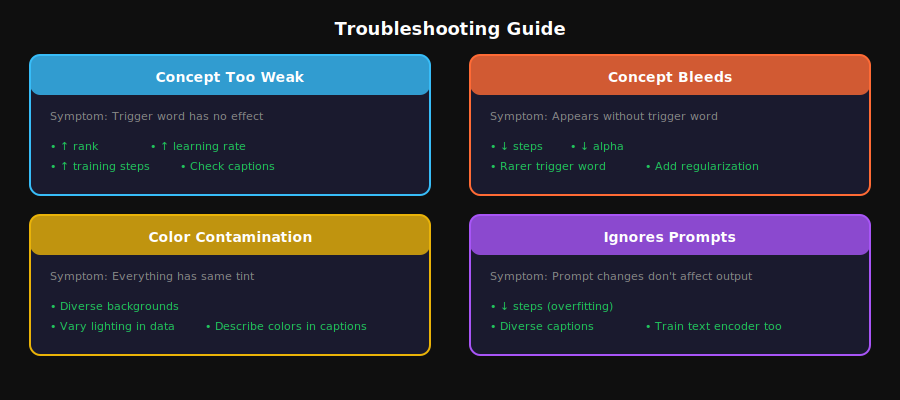

In [181]:
# Failure modes / troubleshooting
display(SVG(ASSETS / 'troubleshooting.svg'))


---
# 6) Practical recipe

**One reliable recipe**
- **Model**: FLUX.2 [klein] Base 4B
- **Rank/Alpha**: 16–32, alpha = rank
- **LR**: 1e‑4 to 3e‑4
- **Steps**: 500–1200 (watch for overfit)
- **Targets**: attention layers attention across all blocks
- **Data**: 20–100 *great* images, unique trigger, diverse contexts

**Stop training if**
- Concept appears without trigger
- Prompt changes stop affecting output
- Validation/sample quality peaks then degrades


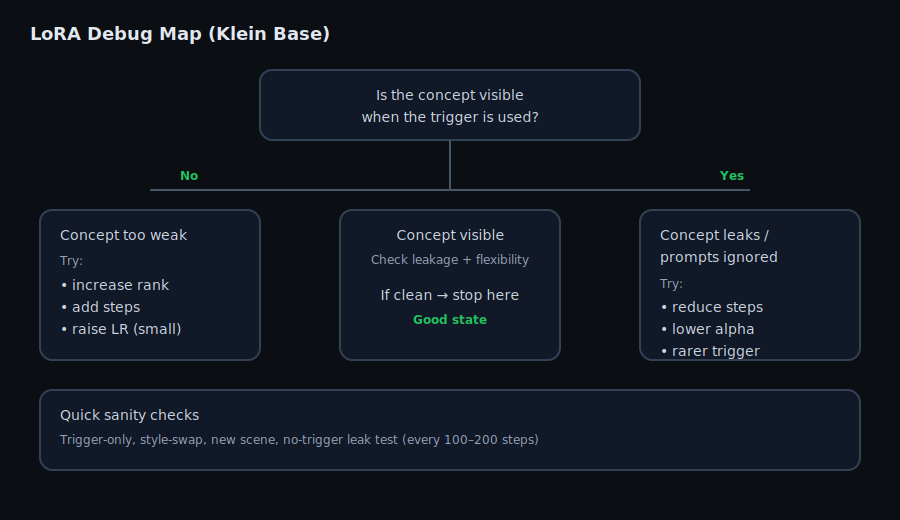

In [182]:
from IPython.display import SVG, display
from pathlib import Path

display(SVG(Path('assets') / 'decision_tree.svg'))


6.2 Minimal training loop

1. Curate dataset + captions
2. Choose targets (attention layers)
3. Train 500–1200 steps
4. Evaluate prompt suite every 100–200 steps
5. Stop when quality peaks

**Key idea:** sampling during training beats watching loss alone.


---
# Closing 

1. **Klein Base (non‑distilled) is the training target**.
2. **Where you place LoRA matters** (double‑stream vs single‑stream).
3. **Rank/steps/LR** are the primary levers.
4. **Data quality** is the biggest driver of success.
5. **Validate with prompts, not just loss.**


## Github link -> [https://github.com/stephen37/workshops](https://github.com/stephen37/workshops)
